Notebook to experiment with observables: 
- Initially we had luminosity function, median of (Mr - Balmer ratio), and median of (Mr - FUV-NUV). This ended up being messy because there were Mr bins without galaxies
- Next, I tried a 3d histogram of the (Mr - Balmer ratio - FUV-NUV)
- Turns out Balmer ratio is super noisy, so I'm now going with (Mr - G-R color - FUV-NUV)
- 3D histogram is difficult to visualize. Lets go with (Mr - G-R) and (Mr- FUV-NUV)

In [1]:
import os
import h5py
import numpy as np 
# -- plotting --
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
dat_dir = os.environ['GALPOPFM_DIR']

Lets read in SDSS

In [3]:
fsdss = os.path.join(dat_dir, 'obs', 'tinker_SDSS_centrals_M9.7.valueadd.hdf5') 
sdss = h5py.File(fsdss, 'r') 

mr_complete = (sdss['mr_tinker'][...] < -20.) 

z_sdss = sdss['redshift_tinker'][...][mr_complete]/299792.458

Fmag    = sdss['ABSMAG'][...][:,0][mr_complete]
Nmag    = sdss['ABSMAG'][...][:,1][mr_complete]
Rmag    = sdss['mr_tinker'][...][mr_complete]
Gmag    = sdss['mg_tinker'][...][mr_complete]

FUV_NUV =  Fmag - Nmag
G_R = Gmag - Rmag 
print('%f < FUV-NUV < %f' % (FUV_NUV.min(), FUV_NUV.max()))
print('%f < G-R < %f' % (G_R.min(), G_R.max()))

zmax = z_sdss.max()
zmin = z_sdss.min() 
print('%f < z_sdss < %f' % (zmin, zmax))

-8.913282 < FUV-NUV < 26.203045
0.280000 < G-R < 1.430000
0.010707 < z_sdss < 0.033390


In [4]:
from astropy.cosmology import Planck13 as cosmo
vol_sdss = (cosmo.comoving_volume(zmax).value - cosmo.comoving_volume(zmin).value) * (7966./41253.) * cosmo.h**3 # (Mpc/h)^3

In [5]:
data_vector = np.array([-1.*Rmag, G_R, FUV_NUV]).T

In [6]:
# don't touch these values!
nbins = [8, 200, 100]
ranges = [(20, 24), (-5., 45.), (-5, 45.)]

In [7]:
Nbins, edges = np.histogramdd(data_vector, bins=nbins, range=ranges)
r_edges = edges[0] 
gr_edges = edges[1]
fn_edges = edges[2]

In [8]:
dr = r_edges[1] - r_edges[0]
dgr = gr_edges[1] - gr_edges[0]
dfn = fn_edges[1] - fn_edges[0]
print(dr, dgr, dfn)

0.5 0.25 0.5


In [9]:
rho = Nbins.astype(float) / vol_sdss / dr / dgr / dfn
rho_r_gr = dfn * np.sum(rho, axis=2)
rho_r_fn = dgr * np.sum(rho, axis=1)
rho_gr = dr * np.sum(rho_r_gr, axis=0) 
rho_fn = dr * np.sum(rho_r_fn, axis=0) 

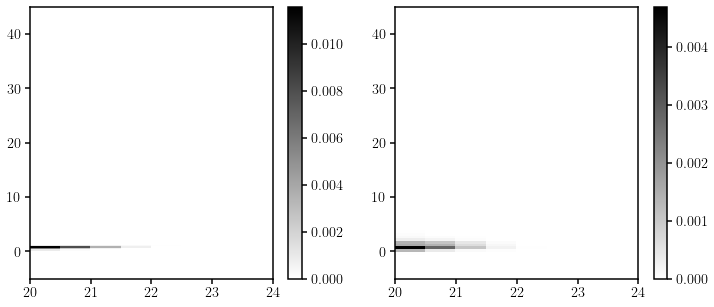

In [11]:
fig = plt.figure(figsize=(12,5))
sub = fig.add_subplot(121)
h = sub.pcolormesh(r_edges, gr_edges, rho_r_gr.T, cmap='gist_gray_r')
plt.colorbar(h, ax=sub)

sub = fig.add_subplot(122)
h = sub.pcolormesh(r_edges, fn_edges, rho_r_fn.T, cmap='gist_gray_r')
plt.colorbar(h, ax=sub)

(-1.0, 10.0)

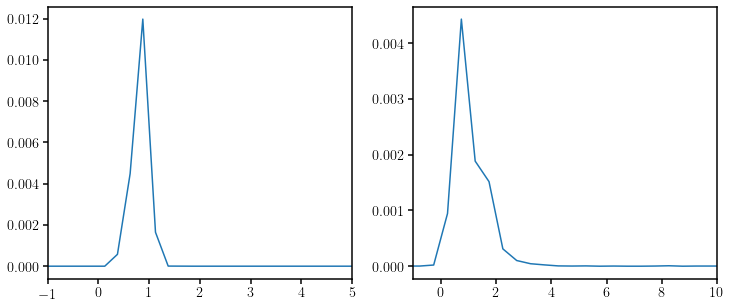

In [19]:
fig = plt.figure(figsize=(12,5))
sub = fig.add_subplot(121)
sub.plot(0.5*(gr_edges[1:] + gr_edges[:-1]), rho_gr)
sub.set_xlim(-1., 5.)

sub = fig.add_subplot(122)
sub.plot(0.5*(fn_edges[1:] + fn_edges[:-1]), rho_fn)
sub.set_xlim(-1., 10.)

Now lets get some uncertainties with jackknife

field 0: 232
field 1: 291
field 2: 467
field 3: 242
field 4: 382
field 5: 705
field 6: 293
field 7: 223
field 8: 491
field 9: 127
field 10: 133


(-30, 90)

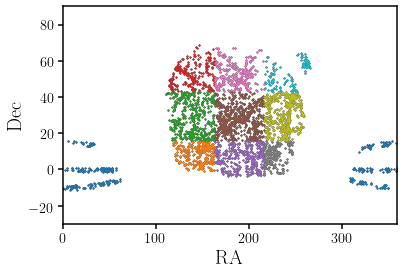

In [12]:
ra_sdss = sdss['RA'][...][mr_complete]
dec_sdss = sdss['DEC'][...][mr_complete]

jk_fields = [] 
jk_fields.append(ra_sdss < 100)

ra_bins = np.linspace(110, 270, 4)
dec_bins = np.linspace(-11., 70., 4)
for i in range(len(ra_bins)-1): 
    for j in range(len(dec_bins)-1): 
        infield = ((ra_sdss > ra_bins[i]) & (ra_sdss < ra_bins[i+1]) & 
                   (dec_sdss > dec_bins[j]) & (dec_sdss < dec_bins[j+1]))
        jk_fields.append(infield)
jk_fields.append(ra_sdss > 300)

for i, field in enumerate(jk_fields): 
    print('field %i: %i' % (i, np.sum(field)))
    
plt.scatter(ra_sdss, dec_sdss, c='k', s=1)
for field in jk_fields: 
    plt.scatter(ra_sdss[field], dec_sdss[field], s=1)
plt.xlabel('RA', fontsize=20)
plt.xlim(0., 360)
plt.ylabel('Dec', fontsize=20)
plt.ylim(-30, 90)

In [14]:
jk_rhos, jk_rhos_r_gr, jk_rhos_r_fn, jk_rhos_gr, jk_rhos_fn = [], [], [], [], []
for field in jk_fields: 
    _data_vector = np.array([-1.*Rmag[~field], G_R[~field], FUV_NUV[~field]]).T    
    _Nbins, _ = np.histogramdd(_data_vector, bins=nbins, range=ranges)

    _rho = _Nbins.astype(float) / vol_sdss / dr / dgr / dfn
    
    jk_rhos.append(_rho)
    jk_rhos_r_gr.append(dfn * np.sum(_rho, axis=2))
    jk_rhos_r_fn.append(dgr * np.sum(_rho, axis=1))
    jk_rhos_gr.append(dr * np.sum(dfn * np.sum(_rho, axis=2), axis=0))
    jk_rhos_fn.append(dr * np.sum(dgr * np.sum(_rho, axis=1), axis=0))
n_jk = len(jk_fields)

jk_avg_rho = np.sum(np.array(jk_rhos), axis=0)/float(n_jk)
jk_avg_rho_r_gr = np.sum(np.array(jk_rhos_r_gr), axis=0)/float(n_jk)
jk_avg_rho_r_fn = np.sum(np.array(jk_rhos_r_fn), axis=0)/float(n_jk)
jk_avg_rho_gr = np.sum(np.array(jk_rhos_gr), axis=0)/float(n_jk)
jk_avg_rho_fn = np.sum(np.array(jk_rhos_fn), axis=0)/float(n_jk)

err_rho = np.sqrt(float(n_jk-1)/float(n_jk)*np.sum(np.array([(_rho - jk_avg_rho)**2 for _rho in jk_rhos]), axis=0))
err_rho_r_gr = np.sqrt(float(n_jk-1)/float(n_jk)*np.sum(np.array([(_rho - jk_avg_rho_r_gr)**2 for _rho in jk_rhos_r_gr]), axis=0))
err_rho_r_fn = np.sqrt(float(n_jk-1)/float(n_jk)*np.sum(np.array([(_rho - jk_avg_rho_r_fn)**2 for _rho in jk_rhos_r_fn]), axis=0))
err_rho_gr = np.sqrt(float(n_jk-1)/float(n_jk)*np.sum(np.array([(_rho - jk_avg_rho_gr)**2 for _rho in jk_rhos_gr]), axis=0))
err_rho_fn = np.sqrt(float(n_jk-1)/float(n_jk)*np.sum(np.array([(_rho - jk_avg_rho_fn)**2 for _rho in jk_rhos_fn]), axis=0))

Lets add some poisson noise for bins without any galaxies

In [15]:
err_poisson = 1. / vol_sdss / dr / dgr / dfn
err_r_gr_poisson = 1. / vol_sdss / dr / dgr
err_r_fn_poisson = 1. / vol_sdss / dr / dfn
err_gr_poisson = 1. / vol_sdss / dgr
err_fn_poisson = 1. / vol_sdss / dfn

In [16]:
err_rho = np.clip(err_rho, err_poisson, None)
err_rho_r_gr = np.clip(err_rho_r_gr, err_r_gr_poisson, None)
err_rho_r_fn = np.clip(err_rho_r_fn, err_r_fn_poisson, None)
err_rho_gr = np.clip(err_rho_gr, err_gr_poisson, None)
err_rho_fn = np.clip(err_rho_fn, err_fn_poisson, None)

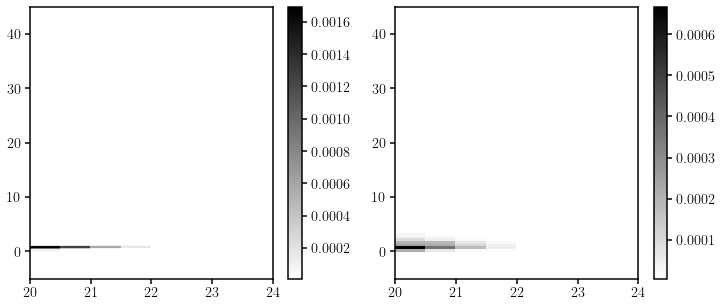

In [18]:
# this is not accurate because you can't add jackknife errors in quadrature
# but for demonstrative purpose.
fig = plt.figure(figsize=(12,5))
sub = fig.add_subplot(121)
h = sub.pcolormesh(r_edges, gr_edges, err_rho_r_gr.T, cmap='gist_gray_r')
plt.colorbar(h, ax=sub)

sub = fig.add_subplot(122)
h = sub.pcolormesh(r_edges, fn_edges, err_rho_r_fn.T, cmap='gist_gray_r')
plt.colorbar(h, ax=sub)

In [20]:
f_obs = os.path.join(dat_dir, 'obs', 'tinker_SDSS_centrals_M9.7.Mr_complete.Mr_GR_FUVNUV.npy') 
np.save(f_obs, [r_edges, gr_edges, fn_edges, rho, err_rho], allow_pickle=True)

In [22]:
f_obs = os.path.join(dat_dir, 'obs', 'tinker_SDSS_centrals_M9.7.Mr_complete.Mr_GR.Mr_FUVNUV.npy') 
np.save(f_obs, [r_edges, gr_edges, fn_edges, rho_r_gr, rho_r_fn, err_rho_r_gr, err_rho_r_fn], allow_pickle=True)

In [23]:
f_obs = os.path.join(dat_dir, 'obs', 'tinker_SDSS_centrals_M9.7.Mr_complete.Mr.GR.FUVNUV.npy') 
np.save(f_obs, [r_edges, gr_edges, fn_edges, rho_gr, rho_fn, err_rho_gr, err_rho_fn], allow_pickle=True)